# 4. Modeling

1. Import packages and dataset
2. Dimensionality reduction
3. Modeling with K-Means Clustering
    - K selection
    - Modeling and cluster sizes
4. Modeling with alternative algorithms
    - Agglomerative Hierarchical Clustering
    - DBSCAN Clustering
    - Mean-Shift Clustering
    - Expectation Maximization Clustering
5. Visualize results
6. Customer segments profiling

---
## 4.1. Import packages and dataset

In [1]:
# Import the required packages

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Set visual style for plots
plt.style.use('seaborn')

In [3]:
# Import pre-processed dataset and load it into a dataframe

# Create path variables
scaled_file = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/processed/preprocessed.csv'
original_file = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/processed/non_preprocessed.csv'

# Load csv in dataframe
df = pd.read_csv(scaled_file, index_col=0)
dfo = pd.read_csv(original_file, index_col=0)

In [4]:
# Check # of columns and rows imported
df.shape

(15710, 91)

In [5]:
# Check # of columns and rows imported
dfo.shape

(15710, 27)

---
## 4.2. Dimensionality reduction

This step entails the reduction of features to allow faster computation without losing much information from those features eliminated. We will use the Principal Component Analysis algorithm (PCA) to find synthetic attributes that represents the largest variability in the data and hence contain the most valuable information.

In [6]:
# Creates working numpy array from dataset
x_cols = df.to_numpy()

We will plot the explained variance of the data against the number of components to find the optimal number, namely a good fair balance between the most efficient dataset (lowest dimension) and sufficient information.

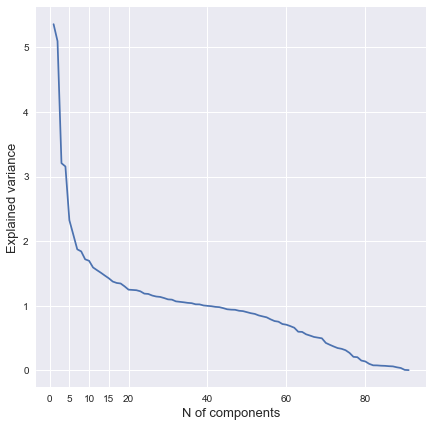

In [7]:
# Initialize a new PCA model with a default number of components.
pca = PCA()
pca.fit(x_cols)

# Compute the explained variance by component
explained_variance = pca.explained_variance_

# Plot explained variance
fig = plt.figure(figsize=(7,7))
plt.plot(np.arange(1,92,1), explained_variance)
plt.xlabel('N of components', fontsize=13)
plt.ylabel('Explained variance', fontsize=13)
plt.xticks([0,5,10,15,20,40,60,80])
plt.show()

It seems that the optimal number of components to which we can reduce our dataset lays between __5 and 15__, however in order to reduce the dispersion of the samples we will reduce our dataset to only three components.

In [8]:
# Initializes PCA with the 3 components

pca = PCA(n_components=3)
x_3cols = pca.fit_transform(x_cols)

---
## 4.3. Modeling with K-Means Clustering

In this section, we will use the K-Means Clustering algorithm to classify our observations. In the first step, we need to specify the number of clusters we want the model creates. We will perform three different methods to figure out a priori this number:
- The Elbow Method
- The Silhouette Coefficient Method
- Clustering observation with t-SNE

### 4.3.1. K Selection: 

__a. The Elbow Method__

This method presents the cluster compactness measured by the inertia score (Sum-of-squares errors) versus the number of clusters detected. For our case, we will try from 2 to 6 clusters.  

In [9]:
# Creates empty list to store inertia values
iner = []

# Calculates inertia for the number of clusters selected 
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i).fit(x_3cols)
    iner.append(kmeans.inertia_)

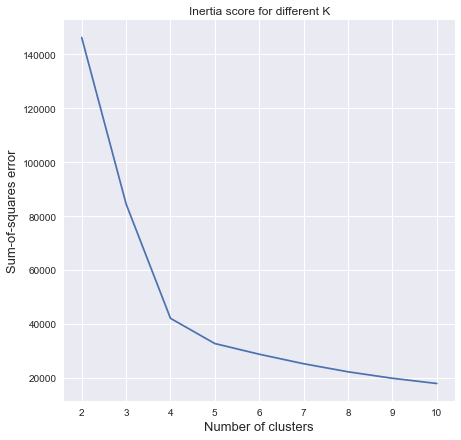

In [10]:
# Creates x axis for the plot with number of clusters
xs = np.arange(2, 11, 1)

# Creates figure and plot
fig, ax1 = plt.subplots(figsize=(7,7))
ax1.plot(xs, iner)
ax1.set_title('Inertia score for different K')
ax1.set_xlabel('Number of clusters', fontsize=13)
ax1.set_xticks([2,3,4,5,6,7,8,9,10])
ax1.set_ylabel('Sum-of-squares error', fontsize=13)

plt.show()

We can see that the reduction of inertias starts to decrease from __4__ clusters onwards 

__b. The Silhouette Coefficient Method__

This method entails the calculation of the silhouette score for every numbre of clusters selected. The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample. 

For n_clusters = 2 The average silhouette_score is : 0.5760361692108813
For n_clusters = 3 The average silhouette_score is : 0.5363883632524862
For n_clusters = 4 The average silhouette_score is : 0.5844564079678436
For n_clusters = 5 The average silhouette_score is : 0.4850167048268536
For n_clusters = 6 The average silhouette_score is : 0.3668719087934721
For n_clusters = 7 The average silhouette_score is : 0.36341343076492677


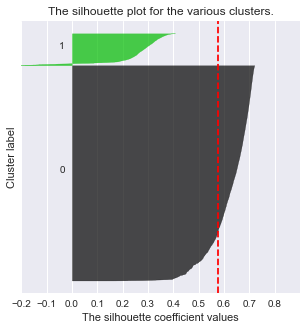

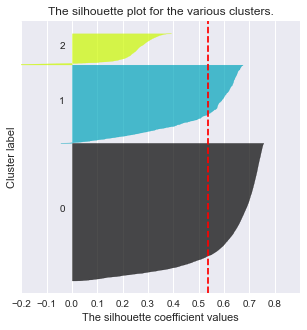

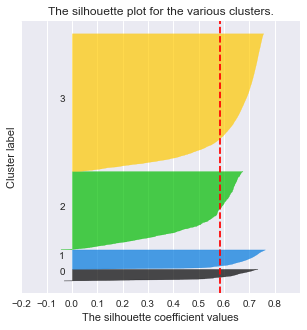

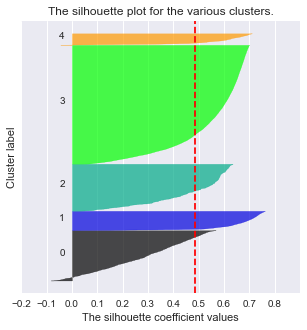

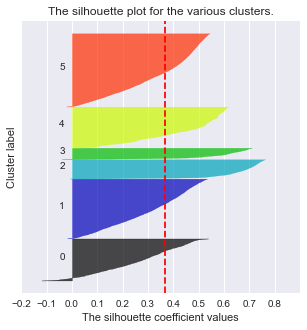

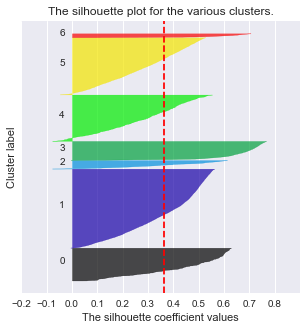

In [11]:
# Selects the number of clusters to test
range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(figsize=(5,5))

    # The silhouette coefficient can range from -1, 1 but in this case all lie within [-0.2, 0.9]
    ax1.set_xlim([-0.2, 0.9])
    ax1.margins(0.05)

    # Initialize the clusterer with n_clusters value and a random generator seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_3cols)

    # The silhouette_score gives the average value for all the samples. This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x_3cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_3cols, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    
plt.show()

We can see that the best average silhouette scores are achieved with __4__ clusters. Moreover the graphs show that there are at least three strongly cohesive clusters 

__c. Clusters visualization with t-SNE__

The last method consists on visually discovering apparent blobs in the data. We will use t-distributed Stochastic Neighbor Embedding algorithm to ploting the samples in 2D.

In [12]:
t_sne = TSNE(learning_rate=5, n_jobs=-1)
transformed = t_sne.fit_transform(x_3cols)
xs = transformed[:,0]
ys = transformed[:,1]

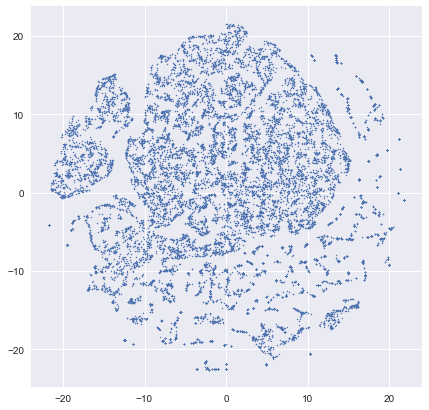

In [13]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(xs, ys, s=5, marker='.')
plt.show()

The graph above does not show any apparent structure in the data.

__We can conclude from the tests above that the optimal number of clusters is four. Moreover, it is reasonable for a hotel to segment customers into four groups to target their customers accurately and efficiently.__

### 4.3.2. Modelling and cluster sizes

Finally, we will model the data with K-Means algorithm using K=4 as input.

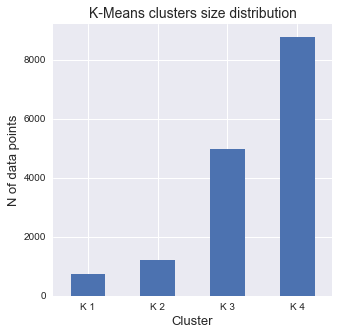

In [14]:
# Initializes the model with selected K, fit and predict the labels for the dataset
kmeans = KMeans(n_clusters=4, random_state=42).fit(x_3cols)
labels_km = kmeans.predict(x_3cols)

# Creates dataframe with the labels
kmeans_df = pd.DataFrame(labels_km, columns=['cluster_id'])

# Create plot
fig = plt.figure(figsize=(5, 5))
kmeans_df.value_counts().sort_index().plot.bar()
plt.xlabel('Cluster', fontsize=13)
plt.title('K-Means clusters size distribution', fontsize=14)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=[0,1,2,3], labels=['K 1','K 2','K 3','K 4'], rotation=0)
plt.show()

As seen in previous sections, there is one large cluster and other smaller two that contain most of the observations. 

In [15]:
# Calculates average silhouette score for 4 clusters
silhouette_km = silhouette_score(x_3cols, labels_km)
print('The Silhouette coefficient for the K-Means Clustering algorithm is '+str(round(silhouette_km, 2)))

The Silhouette coefficient for the K-Means Clustering algorithm is 0.58


---
## 4.4. Modeling with alternative algorithms

In this section four different clustering algorithms are tested and compared with K-Means:
- Agglomerative Hierarchical Clustering
- DBSCAN Clustering
- Mean-Shift Clustering
- Expectation Maximization Clustering

__a. Agglomerative Hierarchical Clustering__

In [16]:
# Initializes and predicts labels
ac_labels = AgglomerativeClustering(n_clusters=4, linkage='ward').fit_predict(x_3cols)
# Calculates average silhouette coefficient
silhouette_ac = silhouette_score(x_3cols, ac_labels)
# Creates dataframe of the labels for later use
agglo_df = pd.DataFrame(ac_labels, columns=['cluster_id'])

The Silhouette coefficient for the Agglomerative Hierarchical Clustering algorithm is 0.57


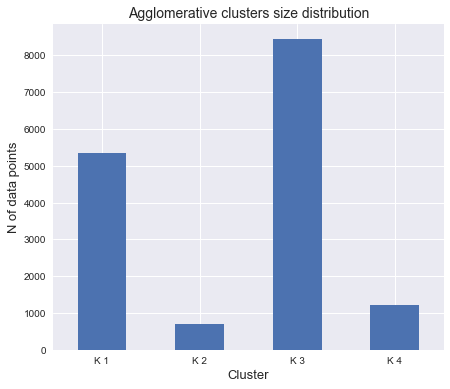

In [17]:
print('The Silhouette coefficient for the Agglomerative Hierarchical Clustering algorithm is '+str(round(silhouette_ac, 2)))

# Creates plot of cluster sizes
agglo_df.value_counts().sort_index().plot.bar(figsize=(7, 6))
plt.title('Agglomerative clusters size distribution', fontsize=14)
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=[0,1,2,3], labels=['K 1','K 2','K 3','K 4'], rotation=0)
plt.show()

__b. DBSCAN algorithm__

In [18]:
# Initializes and predicts labels
db_labels = DBSCAN(eps=1).fit_predict(x_3cols)
# Calculates average silhouette coefficient
silhouette_db = silhouette_score(x_3cols, db_labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
# Creates dataframe of the labels for later use
dbscan_df = pd.DataFrame(db_labels, columns=['cluster_id'])

The number of clusters detected by the DBSCAN algorithm is 4
The Silhouette coefficient for the DBSCAN algorithm is 0.01


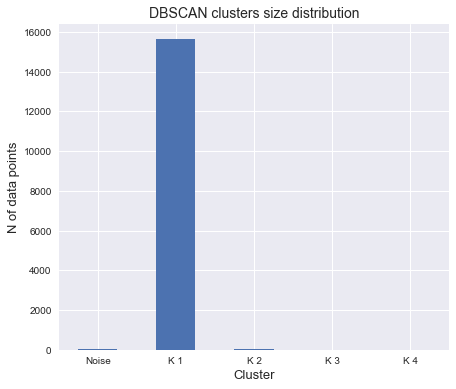

In [19]:
print('The number of clusters detected by the DBSCAN algorithm is '+str(n_clusters_))
print('The Silhouette coefficient for the DBSCAN algorithm is '+str(round(silhouette_db, 2)))

# Creates plot of cluster sizes
dbscan_df.value_counts().sort_index().plot.bar(figsize=(7, 6))
plt.title('DBSCAN clusters size distribution', fontsize=14)
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=range(0,(n_clusters_+1)), labels=['Noise','K 1','K 2','K 3','K 4'], rotation=0)
           
plt.show()

__c. Mean-Shift Algorithm__

In [20]:
# Estimates bandwidth for MeanShift algorithm
bandwidth = estimate_bandwidth(x_3cols, quantile=0.3, n_jobs=-1)

# Initializes and predicts labels
ms_labels = MeanShift(bandwidth=bandwidth).fit_predict(x_3cols)
# Calculates average silhouette coefficient
silhouette_ms = silhouette_score(x_3cols, ms_labels)

# Calculates number of clusters
n_clusters_ = len(set(ms_labels))

# Creates dataframe of the labels for later use
meansh_df = pd.DataFrame(ms_labels, columns=['cluster_id'])

The estimated bandwidth is 2.89
The number of clusters detected by the MeanShift algorithm is 3
The Silhouette coefficient for the MeanShift algorithm is 0.59


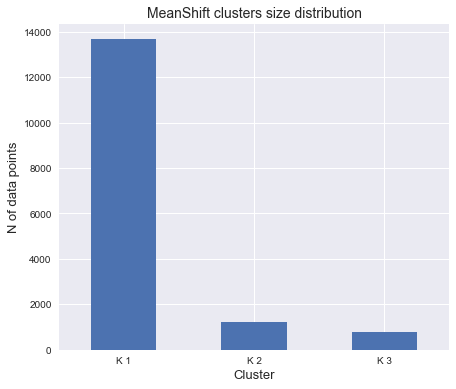

In [21]:
print('The estimated bandwidth is '+str(round(bandwidth, 2)))
print('The number of clusters detected by the MeanShift algorithm is '+str(n_clusters_))
print('The Silhouette coefficient for the MeanShift algorithm is '+str(round(silhouette_ms, 2)))

# Creates plot of cluster sizes
meansh_df.value_counts().sort_index().plot.bar(figsize=(7, 6))
plt.title('MeanShift clusters size distribution', fontsize=14)
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=[0,1,2], labels=['K 1','K 2','K 3'], rotation=0)
           
plt.show()

__d. Expectation Maximization (EM)__

In [22]:
# Initializes and predicts labels
gm_labels = GaussianMixture(n_components=4, covariance_type='full').fit_predict(x_3cols)
# Calculates average silhouette coefficient
silhouette_gm = silhouette_score(x_3cols, gm_labels)
# Creates dataframe of the labels for later use
gaussmix_df = pd.DataFrame(gm_labels, columns=['cluster_id'])

The Silhouette coefficient for the EM Clustering algorithm is 0.55


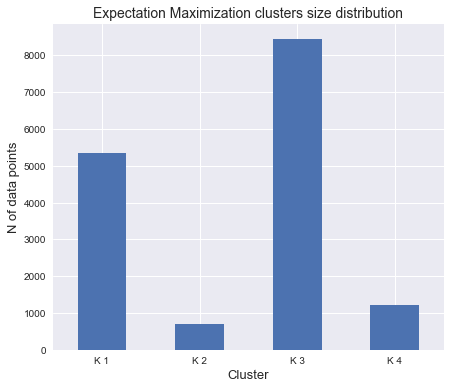

In [23]:
print('The Silhouette coefficient for the EM Clustering algorithm is '+str(round(silhouette_gm, 2)))

# Creates plot of cluster sizes
agglo_df.value_counts().sort_index().plot.bar(figsize=(7, 6))
plt.title('Expectation Maximization clusters size distribution', fontsize=14)
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=[0,1,2,3], labels=['K 1','K 2','K 3','K 4'], rotation=0)
plt.show()

__Performance comparison based on the Silhouette Score__

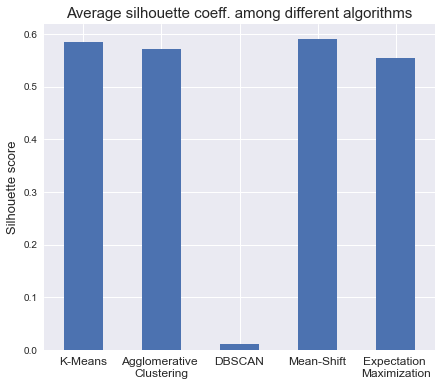

In [24]:
# Create df with results
algorithms = ['K-Means', 'Agglomerative \nClustering', 'DBSCAN', 'Mean-Shift', 'Expectation \nMaximization']
scores = [silhouette_km, silhouette_ac, silhouette_db, silhouette_ms, silhouette_gm]
algorithm_test = pd.DataFrame({'algorithm':algorithms, 'silhouette_score':scores})

# Plot results
algorithm_test.plot.bar(legend=None, figsize=(7, 6))
plt.ylabel('Silhouette score', fontsize=13)
plt.title('Average silhouette coeff. among different algorithms', fontsize=15)
plt.xticks(ticks=[0,1,2,3,4], labels=algorithms, rotation=0, fontsize=12)

plt.show()

Mean-Shift produces the best silhouette score with 0.59. Still, the algorithm selects only three clusters, which is inadequate for the customer segmentation - we need at least four for the segmentation to be useful and accurate. K-Means is the second best algorithm with a 0.58 average silhouette score.

It is worth noting that DBSCAN performed poorly with this dataset, which is expected since our dataset is very sparse, and this algorithm works better for complex spatial structures but tighter datasets.

According to the table below from an article of the University of Berkeley, we can see that all algorithms except DBSCAN found some group structure in the data, showing that there are some customer segments with similar behaviors and preferences. However, the structure is not very strong, and it is necessary to visualize it further to understand these figures.

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

---
## 4.5. Visualizing clusters

In this part, we will plor the dataset in 2D using PCA and label each observation with the results from the K-Means clustering.

In [25]:
# Initialize the pca with 2 components and fit and transform the original dataset
pca = PCA(n_components=2)
x_new = pca.fit_transform(x_cols)

# Create df with the principal components and assign column names
pca_df = pd.DataFrame(x_new, columns=['x', 'y'])

# Joins labels to 2-component dataset
customer_seg = kmeans_df.join(pca_df)

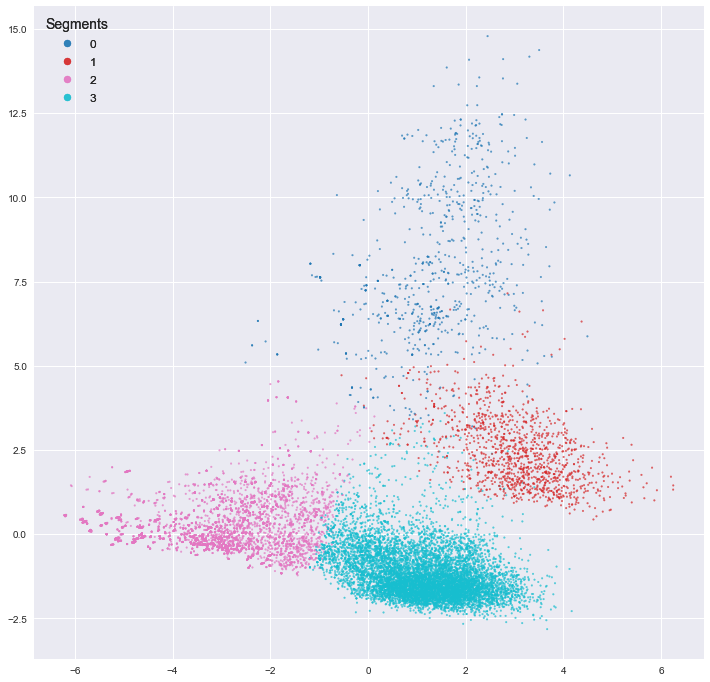

In [26]:
# Creates plot
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter('x', 'y', c='cluster_id', data=customer_seg, alpha=0.7, s=3, cmap='tab10')
legend = ax.legend(*scatter.legend_elements(), loc="upper left", title="Segments", fontsize=12, title_fontsize=14)
ax.add_artist(legend)

plt.show()

We can clearly see from the graph some cluster structure in the data. There is a compact blob for segment __3__ whereas segment __0__ and __1__ are more disperse, meaning more variability in their attributes.

---
## 4.6. Customer segment profiling

Finally, we will compare some statistics of the features grouped by cluster to understand the main attributes that differentiates the customer segments and define a profile for each of them. 

In [27]:
# Reset index in original dataset
dfo.reset_index(inplace=True)
dfo.drop(['index'], axis=1, inplace=True)

# Adds cluster labels to original dataset
dfo_cat_labeled = dfo.select_dtypes(exclude='float64').join(kmeans_df)
dfo_num_labeled = dfo.select_dtypes(include='float64').join(kmeans_df)

In [28]:
# Group observations by cluster label and aggregate for most common value in categories
segments_df_cat = dfo_cat_labeled.groupby(by='cluster_id').agg(lambda x:x.value_counts().index[0])

# Group observations by cluster label and aggregate for mean value in numerical columns
segments_df_num = dfo_num_labeled.groupby(by='cluster_id').median()

In [29]:
# Shows categorical attributes per segment
segments_df_cat.T

cluster_id,0,1,2,3
ArrivalDateMonth,May,August,September,August
StaysInWeekendNights,0,0,0,0
StaysInWeekNights,1,1,2,2
Meal,BB,BB,BB,BB
Country,National,National,National,Other_Europe
MarketSegment,Corporate,Direct,Groups,Online TA
DistributionChannel,Corporate,Direct,TA/TO,TA/TO
IsRepeatedGuest,0,0,0,0
PreviousCancellations,0,0,0,0
PreviousBookingsNotCanceled,0,0,0,0


In [30]:
# shows numerical attributes per segment
segments_df_num.T

cluster_id,0,1,2,3
LeadTime,8.0,22.0,158.00,59.00
Adults,1.0,2.0,2.00,2.00
Children,0.0,0.0,0.00,0.00
Babies,0.0,0.0,0.00,0.00
ADR,75.0,111.8,89.25,108.95


---
### Findings and conclusion

The present study has shown an underlying segment structure in the data, and it is possible to establish four customer groups with similar characteristics. However, not all these groups have the same consistency and cohesion. Namely, samples from segments 2 and 3 are closer, meaning that their attributes are more homogeneous. Segments 0 and 1 are more dispersed, and they can even be considered to not forming a group.

A customer profile based on the segments is presented below:


- Customer Segment 0: National business guest who arrives in May, stays one night. This client usually makes the reservation a week in advance, has a contract with the hotel, and pays a discount rate. 


- Customer Segment 1: Tourist national guest who arrives in August and stays one night. He/She usually reserve three weeks in advance directly with the hotel or uses the Agent C, meaning that he/she has done previous research or is a returning customer. This client is the least sensitive to prices and is willing to pay a high rate.


- Customer Segment 2: National group guest who arrives in September and stays two nights, usually makes the reservation through a travel agency with 5-6 months in advance. This guest is very sensitive to prices and is very likely to cancel the reservation.


- Customer Segment 3: Tourist guest from a European country who arrives in August and stays two nights, usually makes a reservation two months in advance through an online agency (Agent A). This customer is not sensitive to prices, so he/she is willing to pay more for the room or ancillary services.